In [2]:
import pandas as pd 
import xgboost as xgb
import numpy as np
import sklearn
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt

In [3]:
property_df = pd.read_csv("../data/curated/full_data.csv")

In [4]:
property_df.head(1)

,index,address,cost_text,Bed,Bath,Park,property_type,desc_head,LocID,longitude,latitude,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Median_tot_hhd_inc_weekly,total_population,SA2_NAME21,duration_mins,Offence Count,SA2_CODE_2021
0,https://www.domain.com.au/warrandyte-vic-3113-...,Warrandyte VIC 3113,875.0,5,3,3,House,mud brick magic,211021262,145.209992,-37.747366,930.0,481.0,3051.0,2779.0,8781.0,Warrandyte - Wonga Park,>50.0,859.0,211021262.0


In [5]:
y = property_df['cost_text'].tolist()

In [6]:
X = property_df.drop(["index", "address", "desc_head", "latitude", "longitude", "LocID", "SA2_CODE_2021"], axis=1)

In [7]:
# encode categorical variables
onehot_columns = ['property_type', 'SA2_NAME21', 'duration_mins']
onehot_df = X[onehot_columns]
onehot_df = pd.get_dummies(onehot_df, columns = onehot_columns)
score_onehot_drop = X.drop(onehot_columns, axis = 1)
score_onehot = pd.concat([score_onehot_drop, onehot_df], axis = 1)

#### XGBoosting

In [10]:
params = { 'max_depth': [3, 6, 10, 15, 20],
           'gamma': [0, 0.25, 0.5],
           'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
           "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': np.arange(0.4, 1.0, 0.1)}


xgbr = xgb.XGBRegressor(random_state=1)

clf = RandomizedSearchCV(estimator=xgbr, 
                   param_distributions=params,
                   scoring='neg_mean_squared_error',
                   n_jobs=-1,
                   n_iter=50,
                   verbose=1)

In [11]:
clf.fit(score_onehot, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/azash/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_ca...
                   param_distributions={'colsample_bylevel': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'colsample_bytree': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'gamma': [0, 0.25, 0.5],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3,
                                                          0.4],
                                        'max_depth': [3, 6, 10, 15, 20],
                                        'n_estimators': [100, 500, 1000],
                                        'reg_alpha': [1e-05, 0.01, 0.1, 1, 10,
                                                      100],
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   scoring='neg_mean_squared_error', verbose=1)

In [12]:
print("Best parameters:", clf.best_params_)

Best parameters: {'subsample': 0.7999999999999999, 'reg_alpha': 0.01, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.4, 'gamma': 0.5, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7999999999999999}


According to our search, the parameters we should use are: {'subsample': 0.7999, 'reg_alpha': 0.01, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.4, 'gamma': 0.5, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7999}

In [23]:
best_model = xgb.XGBRegressor(subsample=0.7999, reg_alpha=0.01, n_estimators=1000, max_depth=3, 
    learning_rate=0.4, gamma=0.5, colsample_bytree=0.7, colsample_bylevel=0.7999)

#### Testing

In [24]:
from sklearn.model_selection import cross_validate
import numpy as np

scoring = ['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']
scores = cross_validate(best_model, score_onehot, y, cv=5, scoring=scoring)

In [21]:
print('R-squared:', np.mean(scores['test_r2']))
print('RMSE', abs(np.mean(scores['test_neg_root_mean_squared_error'])))
print('MAE:', abs(np.mean(scores['test_neg_mean_absolute_error'])))    

R-squared: 0.9980657156308471
RMSE 10.496801627225574
MAE: 4.790118463415102


#### Feature Importance

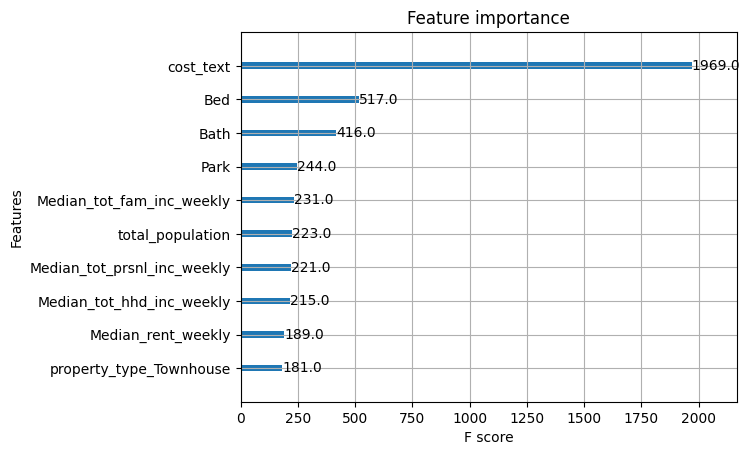

In [25]:
from matplotlib import pyplot
from xgboost import plot_importance

# top 10 most important features
best_model.fit(score_onehot, y)
plot_importance(best_model, max_num_features = 10)
pyplot.show()